# **Brain tumor**

-#https://zenodo.org/records/17524350

📄 **Citation**
If you use BRISC in your work, please cite:

@article{fateh2025brisc,
  title={Brisc: Annotated dataset for brain tumor segmentation and classification with swin-hafnet},
  author={Fateh, Amirreza and Rezvani, Yasin and Moayedi, Sara and Rezvani, Sadjad and Fateh, Fatemeh and Fateh, Mansoor and Abolghasemi, Vahid},
  journal={arXiv preprint arXiv:2506.14318},
  year={2025}
}

# **BRISC Dataset**

This **dataset** contains T1-weighted MRI scans categorized into four tumor types across three anatomical planes.

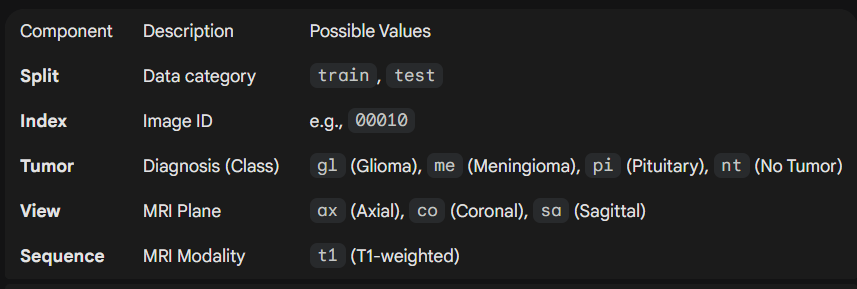

📊 **Dataset Statistics**

Total Images: 6,000

Distribution: 5,000 for Training / 1,000 for Testing.

Balance: All 4 classes and 3 imaging planes are equally represented.


**Sample of the dataset**

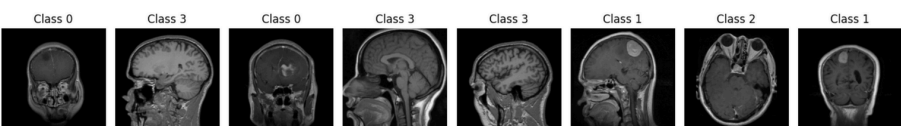

The **model** is a type of deep learning network (a residual CNN) that looks at MRI images through multiple layers to learn the specific shapes and features of different brain tumors.

In [ ]:
from google.colab import files
import zipfile
import os

# 1. Upload the file
uploaded = files.upload()

# 2. Extract the file using the correct path
# We use 'brisc2025.zip' (local path) or '/content/brisc2025.zip' (full path)
with zipfile.ZipFile('/content/brisc2025.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/brisc2025_data')

# 3. Check if it worked
print(os.listdir('/content/brisc2025_data'))

Saving brisc2025.zip to brisc2025.zip
['brisc2025']


# Preprocessing & Data Generators

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 42

TRAIN_DIR = '/content/brisc2025_data/brisc2025/classification_task/train'
TEST_DIR = '/content/brisc2025_data/brisc2025/classification_task/test'

# Train: augmentation + rescale
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.10,
    horizontal_flip=True,
    validation_split=VAL_SPLIT
)

# Val: rescale only
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=VAL_SPLIT
)

# Test: rescale only
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=SEED,
    color_mode="rgb"
)

val_generator = val_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=SEED,
    color_mode="rgb"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    color_mode="rgb"
)

class_names = list(train_generator.class_indices.keys())
num_classes = train_generator.num_classes
print("Classes:", class_names)

import numpy as np
from collections import Counter

def print_class_counts(generator, set_name):
    # Map the numbers (0,1,2,3) to the names
    class_labels = {v: k for k, v in generator.class_indices.items()}
    # Count the occurrences of each class index
    counts = Counter(generator.classes)

    print(f"\n {set_name} Class Breakdown")
    for index in sorted(counts.keys()):
        print(f"Class {index} ({class_labels[index]}): {counts[index]} images")

# Run the count for all sets
print_class_counts(train_generator, "Training Set")
print_class_counts(val_generator, "Validation Set")
print_class_counts(test_generator, "Test Set")

Found 4002 images belonging to 4 classes.
Found 998 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']

 Training Set Class Breakdown
Class 0 (glioma): 918 images
Class 1 (meningioma): 1064 images
Class 2 (no_tumor): 854 images
Class 3 (pituitary): 1166 images

 Validation Set Class Breakdown
Class 0 (glioma): 229 images
Class 1 (meningioma): 265 images
Class 2 (no_tumor): 213 images
Class 3 (pituitary): 291 images

 Test Set Class Breakdown
Class 0 (glioma): 254 images
Class 1 (meningioma): 306 images
Class 2 (no_tumor): 140 images
Class 3 (pituitary): 300 images


# handle class imbalance

In [ ]:

from sklearn.utils.class_weight import compute_class_weight

y_train = train_generator.classes
class_weights_arr = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}
print("Class weights:", class_weights)

Class weights: {0: np.float64(1.0898692810457515), 1: np.float64(0.9403195488721805), 2: np.float64(1.1715456674473068), 3: np.float64(0.8580617495711835)}


## **Building neural network(NN) model from scratch**

In [ ]:
#The Simpler model does not use Batch Normalization, uses layers.Flatten()
# (might memorize the training images) and only 64 filters.

from tensorflow.keras import layers, models

def build_simpler_residual_cnn(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    #Initial Conv and Pool
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    #Single Residual Block
    shortcut = x
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    #Adjust shortcut if number of filters changed
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = layers.Conv2D(x.shape[-1], (1, 1), padding='same')(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.MaxPooling2D((2, 2))(x)

    #Final Classification Block
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

#Create the simpler residual model
simpler_residual_model = build_simpler_residual_cnn((128, 128, 3), 4)
simpler_residual_model.compile(optimizer='adam',    loss='categorical_crossentropy',metrics=['accuracy'])
simpler_residual_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_1[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 64,    │          0 │ conv2d_2[0][0],   │
│                     │ 64)               │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 65536)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  8,388,736 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │        516 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,447,684 (32.23 MB)

 Trainable params: 8,447,684 (32.23 MB)

 Non-trainable params: 0 (0.00 B)

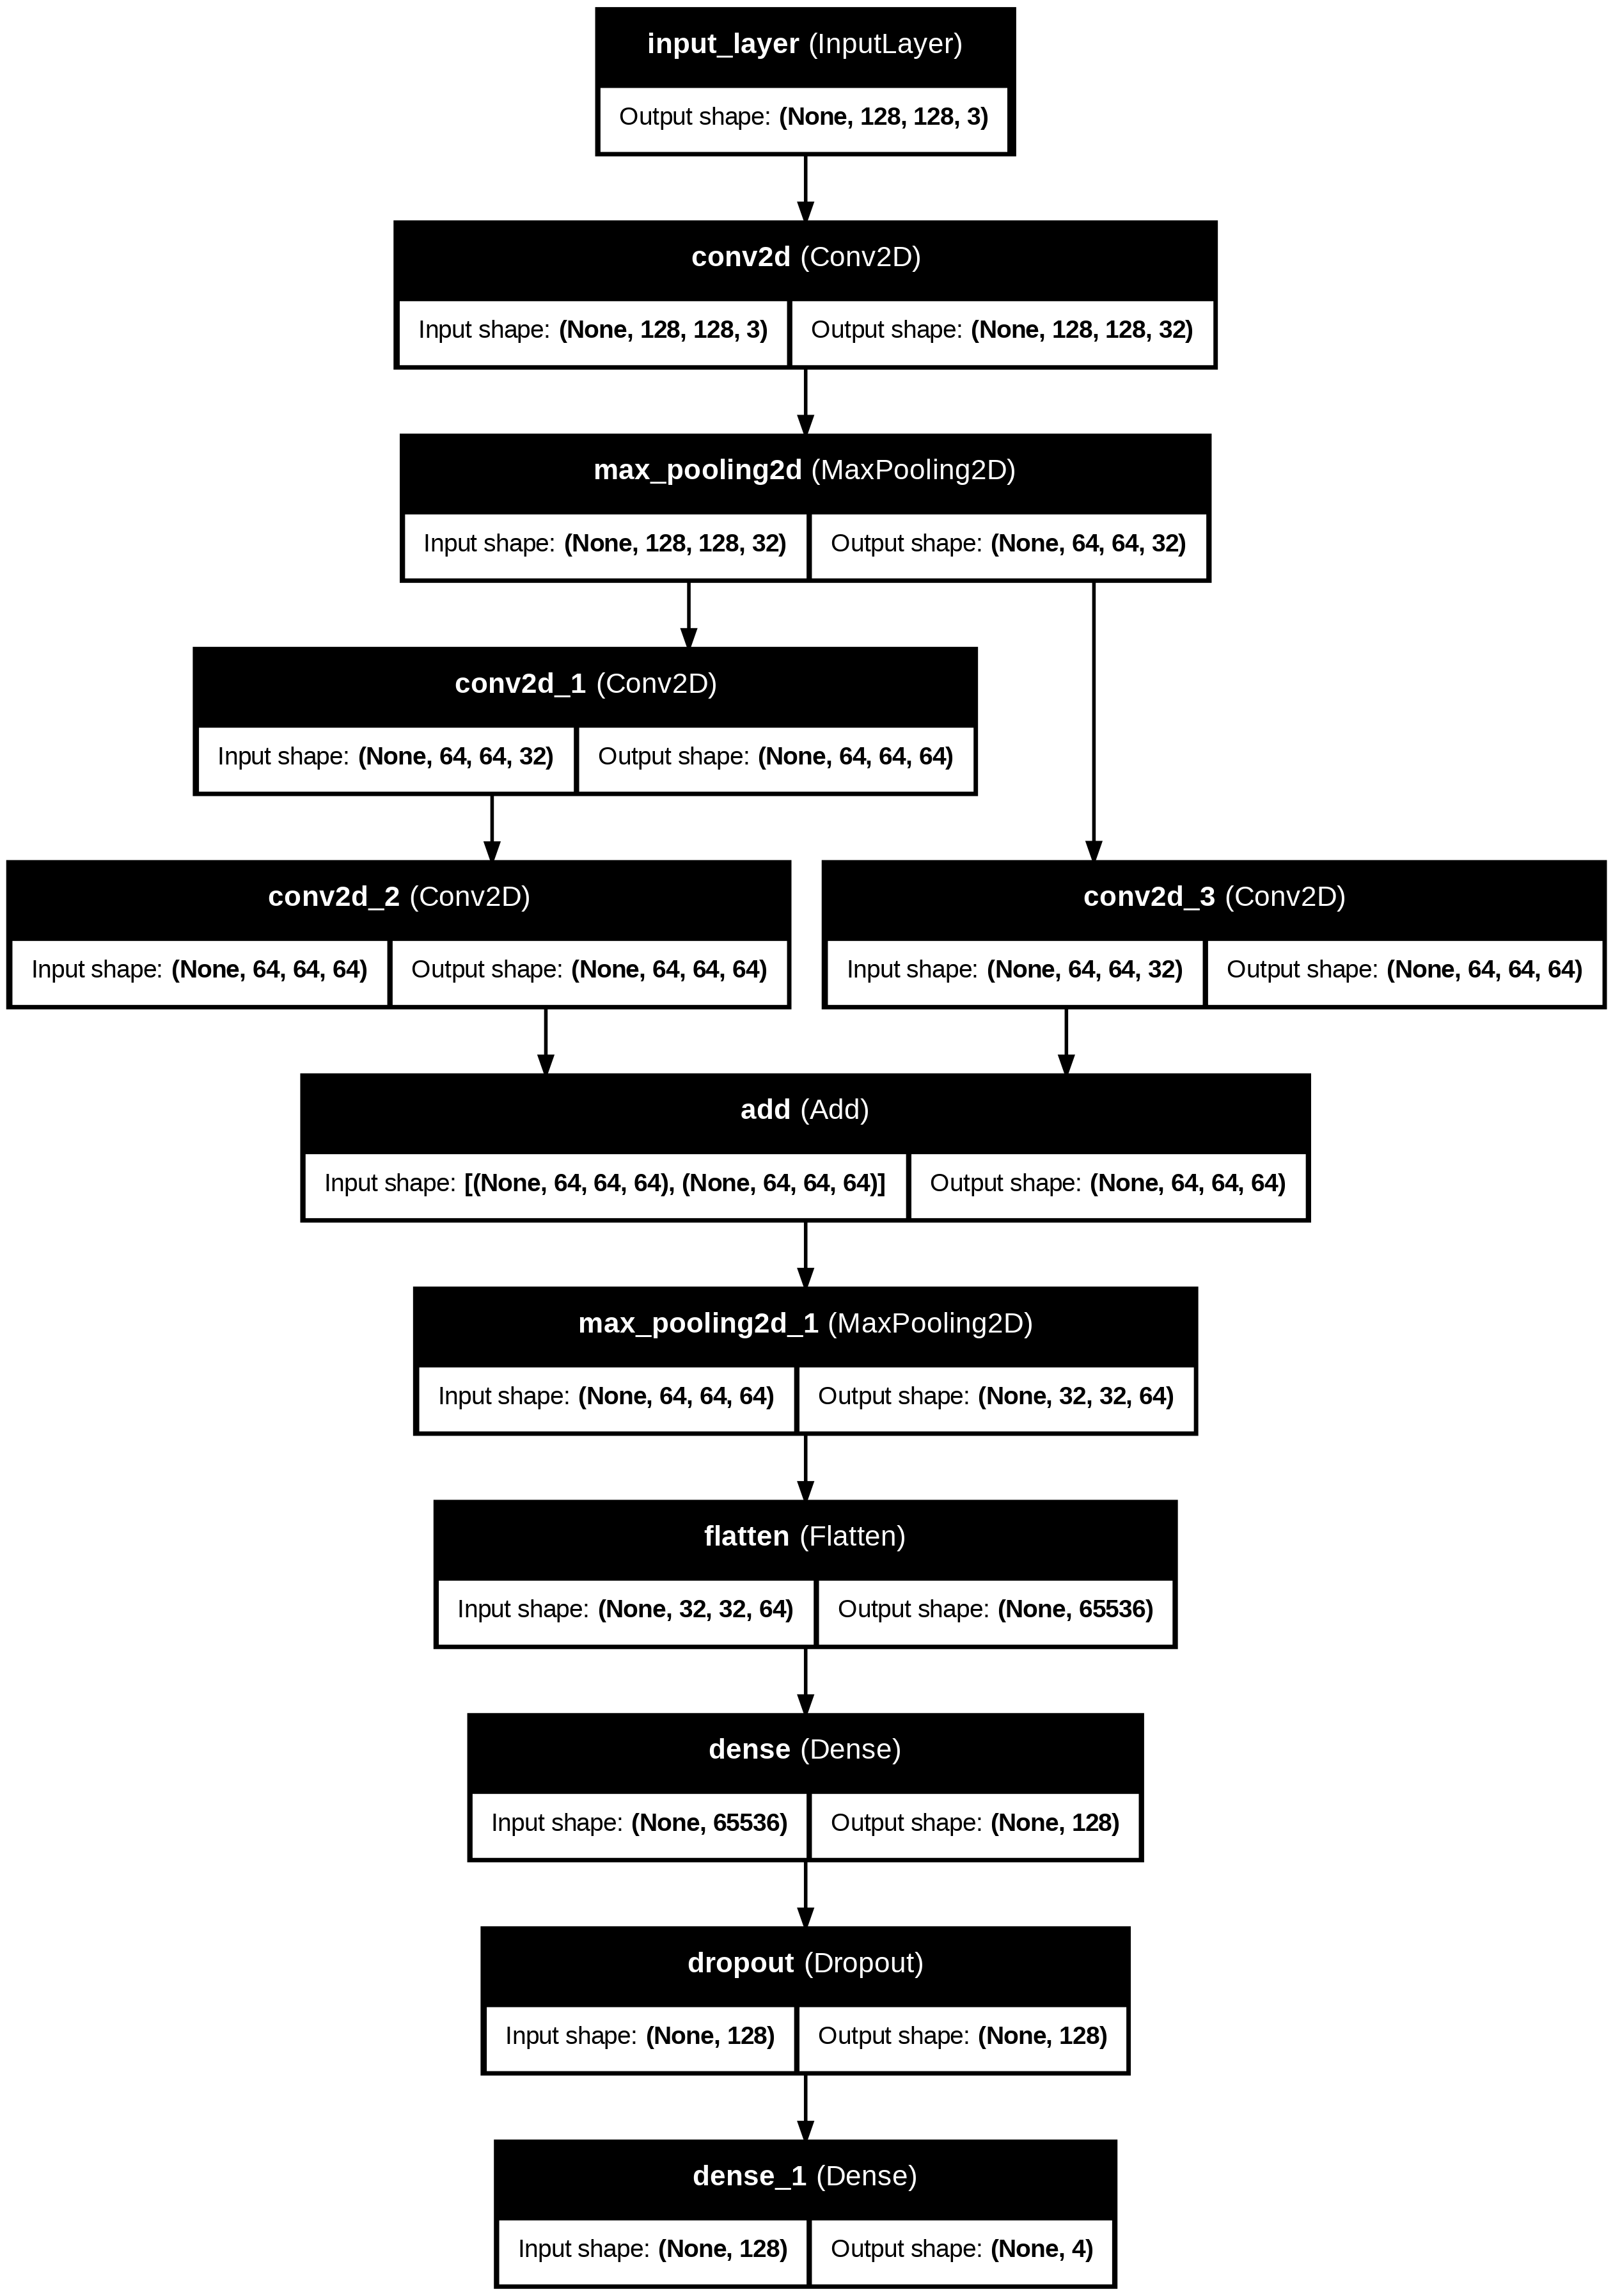

In [ ]:
import tensorflow as tf

tf.keras.utils.plot_model(simpler_residual_model, show_shapes=True, show_layer_names=True, to_file='simpler_residual_model_architecture.png')

# Display the image
from IPython.display import Image
Image('simpler_residual_model_architecture.png')

## **Regularization**

In [ ]:
#regularization
from tensorflow.keras import layers, models, regularizers

def build_efficientnet_classifier(input_shape=(128,128,3), num_classes=3, l2=1e-5, dropout=0.4):
    base = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )
    base.trainable = False  # stage 1: frozen backbone

    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(
        num_classes,
        activation="softmax",
        kernel_regularizer=regularizers.l2(l2)
    )(x)

    model = models.Model(inputs, outputs, name="EfficientNetB0_BRISC")
    return model, base

model, backbone = build_efficientnet_classifier(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    num_classes=num_classes,
    l2=1e-5,
    dropout=0.4
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  #lower LR
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "EfficientNetB0_BRISC"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Training and Evaluation for the Simpler Residual CNN Model

In [ ]:
#Hyperparameter tuning

#Testing 3 different learning rates to find the best one to use
learning_rates = [0.001, 0.0005, 0.0001]
results = {}

for lr in learning_rates:
    print(f"\nTesting Hyperparameter: Learning Rate = {lr}")

    #Rebuild and compile model with specific Learning Rate
    model = build_advanced_resnet((128, 128, 3), 4)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    #Train (fewer epochs to save time during tuning)
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=val_generator,
        callbacks=callbacks_list,
        verbose=0 #clean output
    )

    #Evaluate
    test_generator.reset()
    eval_res = model.evaluate(test_generator, verbose=0)
    results[lr] = eval_res[1]
    print(f"Result for LR {lr}: Test Accuracy = {eval_res[1]*100:.2f}%")

#Best Learning Rate
best_lr = max(results, key=results.get)
print(f"\nBest Hyperparameter: Learning Rate = {best_lr} ({results[best_lr]*100:.2f}%)")


Testing Hyperparameter: Learning Rate = 0.001


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Result for LR 0.001: Test Accuracy = 80.30%

Testing Hyperparameter: Learning Rate = 0.0005
Result for LR 0.0005: Test Accuracy = 77.80%

Testing Hyperparameter: Learning Rate = 0.0001
Result for LR 0.0001: Test Accuracy = 72.70%

🏆 Best Hyperparameter: Learning Rate = 0.001 (80.30%)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#Auto adjust learning rate if accuracy stops improving(lr=0.001 default)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

#Stop training if the model starts overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

callbacks_list = [reduce_lr, early_stop]


In [ ]:
print("\nTraining: Simpler Residual CNN")
history_simpler = simpler_residual_model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=callbacks_list
)

print("\nEvaluating: Simpler Residual CNN")
test_generator.reset()
eval_simpler = simpler_residual_model.evaluate(test_generator)
print(f"Test Loss: {eval_simpler[0]:.4f}")
print(f"Test Accuracy: {eval_simpler[1]*100:.2f}%")


Training: Simpler Residual CNN
Epoch 1/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 214ms/step - accuracy: 0.4053 - loss: 1.5357 - val_accuracy: 0.5431 - val_loss: 1.2130 - learning_rate: 0.0010
Epoch 2/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - accuracy: 0.5930 - loss: 1.0005 - val_accuracy: 0.7014 - val_loss: 0.9531 - learning_rate: 0.0010
Epoch 3/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.6612 - loss: 0.8166 - val_accuracy: 0.7515 - val_loss: 0.8552 - learning_rate: 0.0010
Epoch 4/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 24s 188ms/step - accuracy: 0.7134 - loss: 0.7276 - val_accuracy: 0.7966 - val_loss: 0.9361 - learning_rate: 0.0010
Epoch 5/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 179ms/step - accuracy: 0.7377 - loss: 0.6409 - val_accuracy: 0.7886 - val_loss: 0.9272 - learning_rate: 0.0010
Epoch 6/15
126/126 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - accuracy: 0.7471 - loss: 0.6217 - val_accuracy: 0.7876 - val_loss: 0.9506 - learning_rate: 0.0010
Epoch 7/15
126/126 ━━━━━━━━━━━━━━━━━━━

# **more evaluation**

Macro F1: 0.8067

Classification report:
              precision    recall  f1-score   support

      glioma     0.9836    0.7087    0.8238       254
  meningioma     0.7386    0.6373    0.6842       306
    no_tumor     0.7733    0.9500    0.8526       140
   pituitary     0.7743    0.9833    0.8664       300

    accuracy                         0.8030      1000
   macro avg     0.8174    0.8198    0.8067      1000
weighted avg     0.8164    0.8030    0.7979      1000



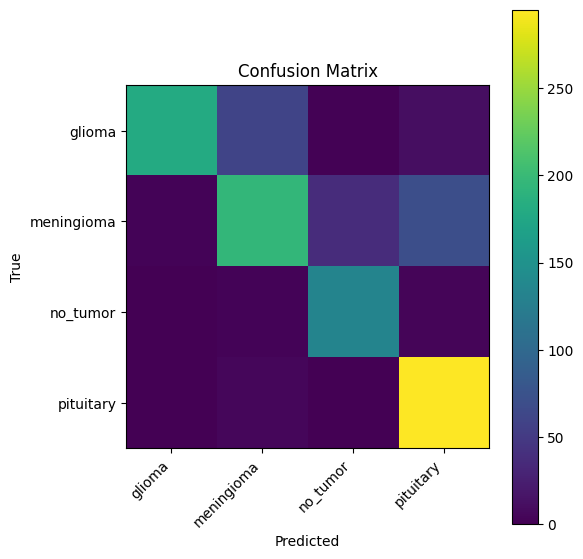

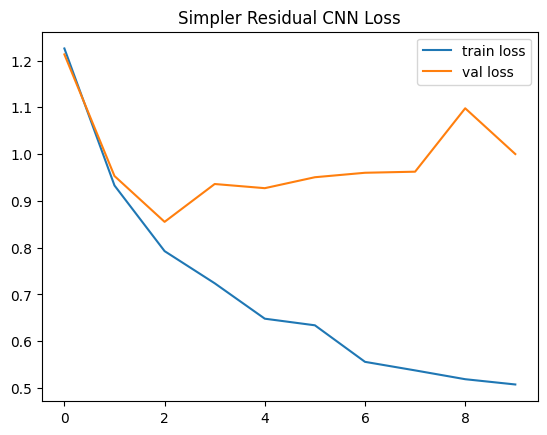

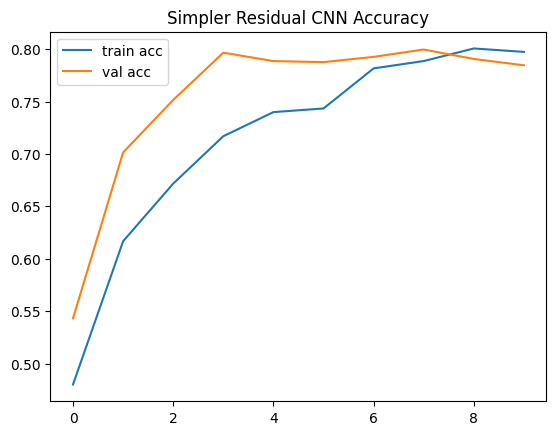

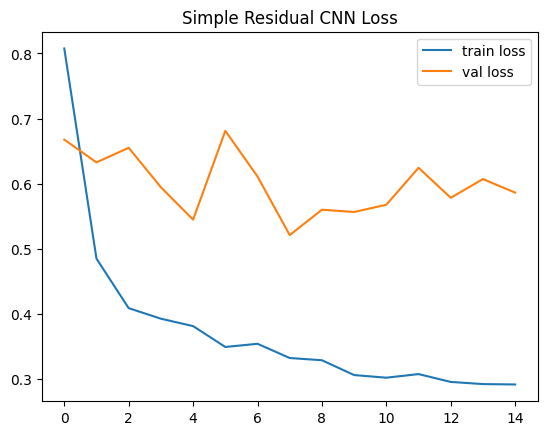

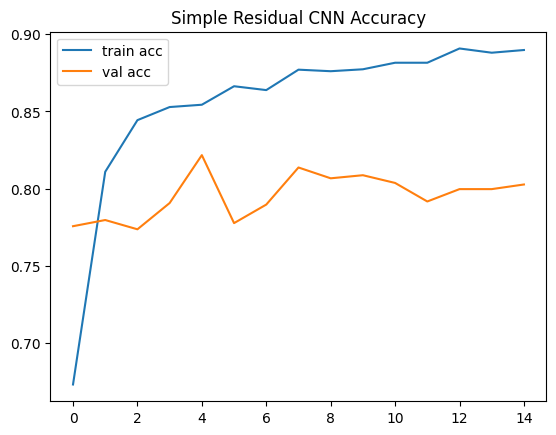

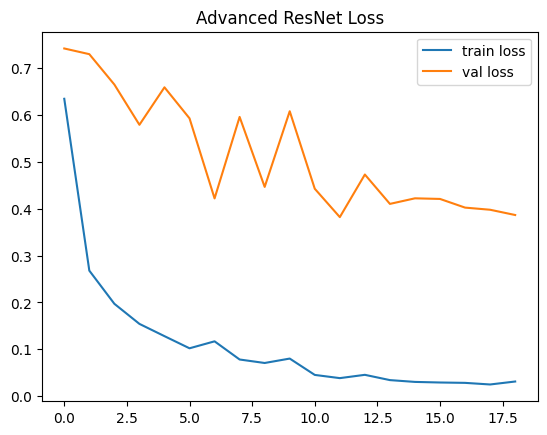

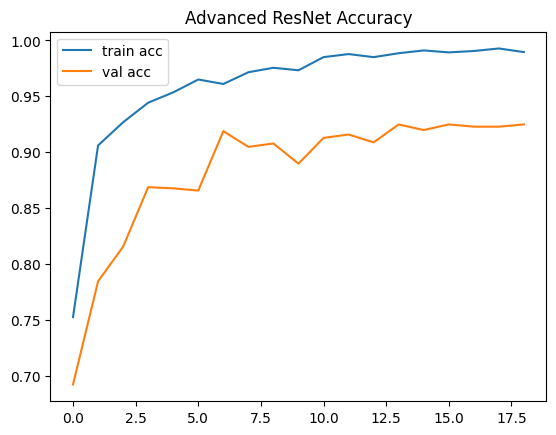

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Predict on test
test_generator.reset()
y_prob = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
y_true = test_generator.classes

print("Macro F1:", round(f1_score(y_true, y_pred, average="macro"), 4))
print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)
plt.tight_layout()
plt.show()

# Curves
def plot_history(hist, title_prefix="Stage"):
    if hist is None:
        return
    plt.figure()
    plt.plot(hist.history.get("loss", []), label="train loss")
    plt.plot(hist.history.get("val_loss", []), label="val loss")
    plt.title(f"{title_prefix} Loss")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(hist.history.get("accuracy", []), label="train acc")
    plt.plot(hist.history.get("val_accuracy", []), label="val acc")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()
    plt.show()

# Corrected calls to plot_history
plot_history(history_simpler, "Simpler Residual CNN")
plot_history(history_simple, "Simple Residual CNN")
plot_history(history_advanced, "Advanced ResNet")

# **Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


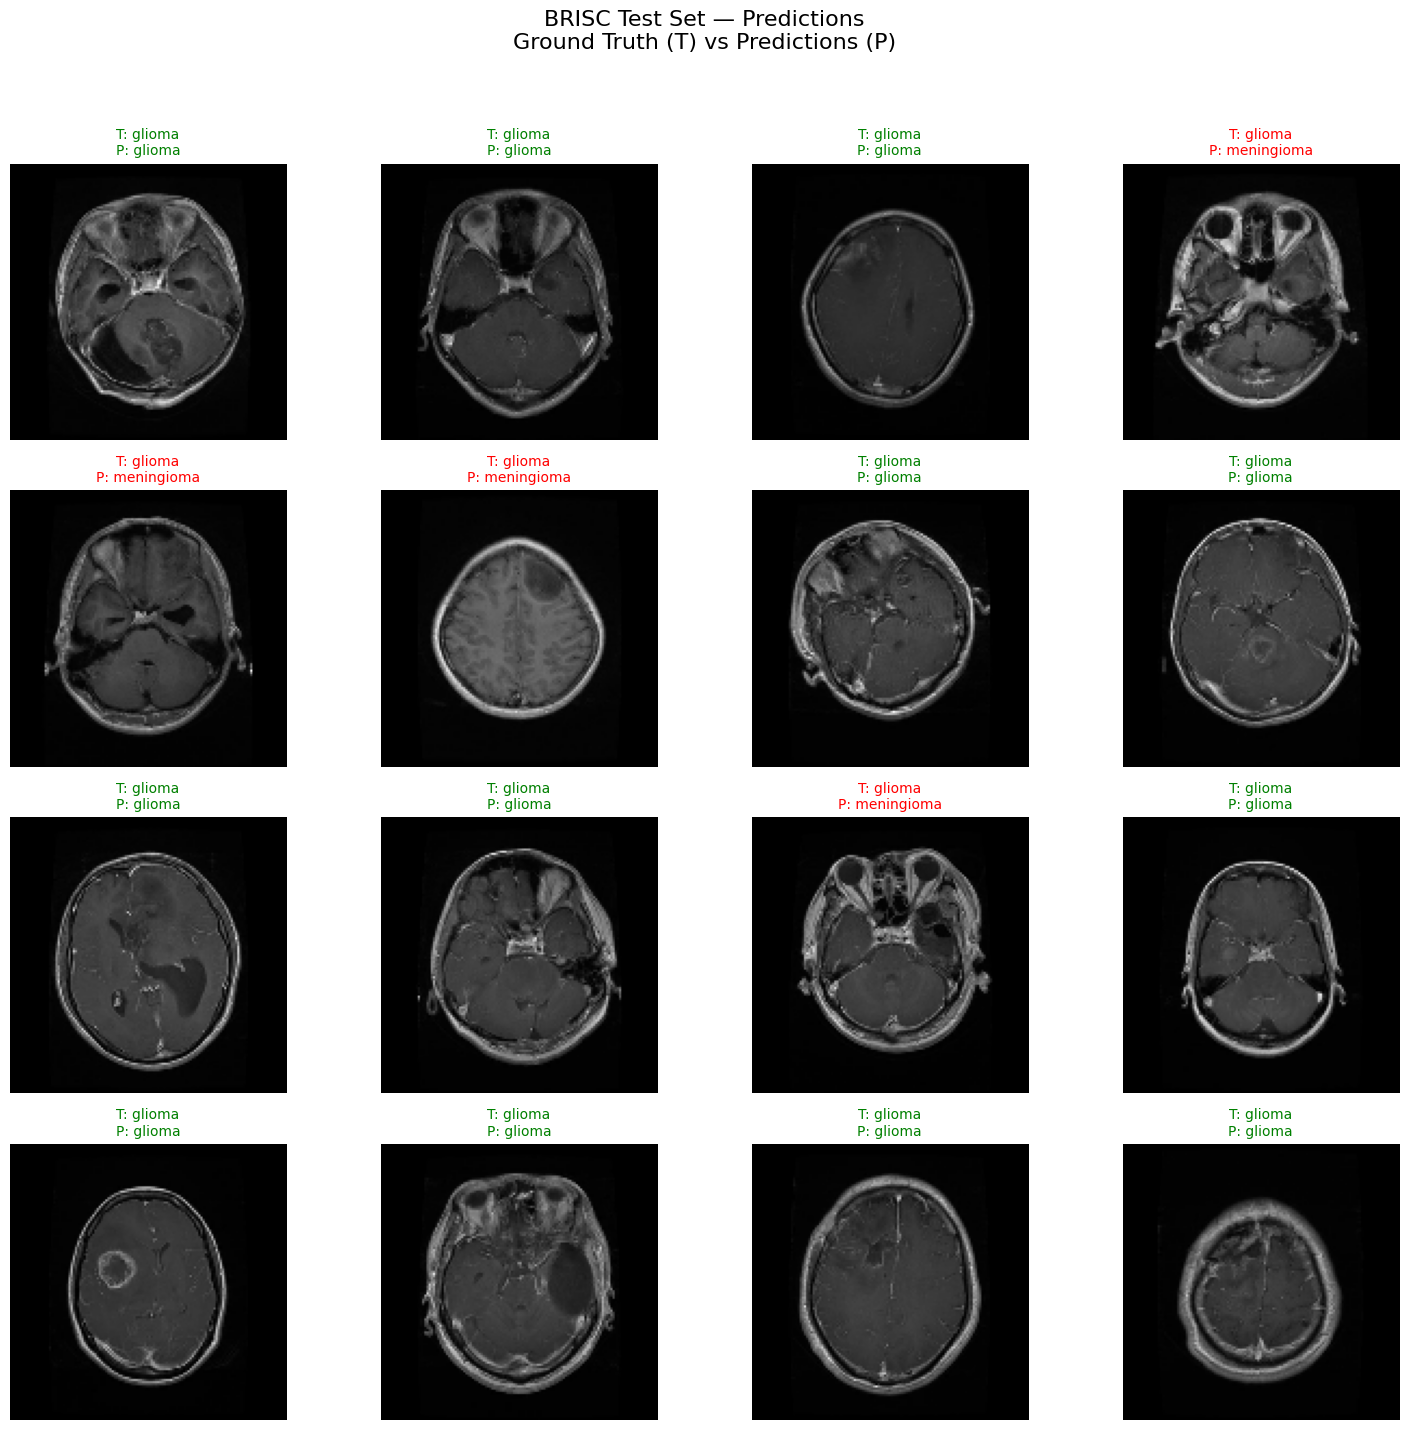

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Get a batch of images from the test generator
#We set shuffle=False in your test_generator, so this will be the first batch
test_generator.reset()
x_batch, y_true_batch = next(test_generator)

#Make predictions on that batch
predictions = model.predict(x_batch)

#Get the class names from generator
class_names = list(test_generator.class_indices.keys())

#Create the Plot (4x4 Grid to show 16 images)
plt.figure(figsize=(15, 15))
plt.suptitle("BRISC Test Set — Predictions\nGround Truth (T) vs Predictions (P)", fontsize=16)

for i in range(16):
    plt.subplot(4, 4, i + 1)

    #Display the MRI image
    plt.imshow(x_batch[i])

    #Get Truth (Actual) and Predicted labels
    actual_idx = np.argmax(y_true_batch[i])
    pred_idx = np.argmax(predictions[i])

    actual_label = class_names[actual_idx]
    pred_label = class_names[pred_idx]

    #Color: Green if correct, Red if wrong
    color = 'green' if actual_idx == pred_idx else 'red'

    plt.title(f"T: {actual_label}\nP: {pred_label}", color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# XAI


In [ ]:
#xai

import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name=None, pred_index=None):
    if last_conv_layer_name is None:
        for layer in reversed(model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                last_conv_layer_name = layer.name
                break

    if last_conv_layer_name is None:
        raise ValueError("Could not find a Conv2D layer in the model for Grad-CAM.")

    grad_model = tf.keras.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy(), last_conv_layer_name

def overlay_heatmap_on_image(img_rgb, heatmap, alpha=0.4):
    img_uint8 = np.uint8(255 * img_rgb)
    heatmap_uint8 = np.uint8(255 * heatmap)

    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(img_uint8, 1.0, heatmap_color, alpha, 0)
    return overlay

test_generator.reset()
x_batch, y_batch = next(test_generator)
y_true_b = np.argmax(y_batch, axis=1)

y_prob_b = modela.predict(x_batch, verbose=0)
y_pred_b = np.argmax(y_prob_b, axis=1)

idx = 0
img = x_batch[idx]
img_array = np.expand_dims(img, axis=0)

heatmap, conv_name = make_gradcam_heatmap(img_array, modela)
overlay = overlay_heatmap_on_image(img, heatmap, alpha=0.45)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title(f"Original\nTrue: {class_names[y_true_b[idx]]}")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title(f"Heatmap\n{conv_name}")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay\nPred: {class_names[y_pred_b[idx]]}")
plt.axis("off")

plt.tight_layout()
plt.show()

ValueError: Could not find a Conv2D layer in the model for Grad-CAM.